In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size' : 22})
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import joblib

In [5]:
def thin(n_left, n_right, R):
    '''
    Thin lens formula. 
    Returns the dioptric power of a thin lens
    Inputs = radius of curvature, left and right refractive indices.
    /!\ The radius is positive if the lens is convex and negative if the lens is concave.
    For example : both radius of the cornea have positive signs.
    For a biconvex IOL, the anterior radius is positive, and the posterior radius is negative.
    R = in meters
    '''
    power = (n_right - n_left) / R
    return power

In [6]:
def gullstrand(P_left, P_right, thickness, n):
    '''
    Gullstrand formula. 
    Returns the power of the thick lens
    Inputs = dioptric power of each surface, thickness of the lens studied (meters), 
    refractive index of the lens studied
    '''
    power = P_left + P_right - (thickness * P_left * P_right / n)
    return power

In [7]:
def convertSpectaclesToCornea(Spec_ref,d):
    '''
    Converts the refraction measured in the spectacle plane to the corresponding refraction 
    in the corneal plane. d = vertex distance in meters. SE = diopters.
    '''
    K_ref = Spec_ref /(1 - d * Spec_ref)
    return K_ref

In [8]:
def convertCorneaToSpectacles(K_ref,d):
    '''
    Converts the refraction measured in the spectacle plane to the corresponding refraction 
    in the corneal plane. d = vertex distance in meters. SE = diopters.
    '''
    Spec_ref = K_ref /(1 + d * K_ref)
    return Spec_ref

In [9]:
def FFLBFL(n_left, n_right, power):
    '''
    Returns the front focal length and the back focal length of the lens
    Inputs = power of the lens and surrounding refractive indices values
    '''
    ffl = - n_left / power
    bfl = n_right / power
    return ffl, bfl

In [10]:
def FPPSPP(delta, ffl_thick, ffl_right, bfl_thick, bfl_left):
    '''
    Returns the first principale plane and second principale planes of a thick lens from :
    - lens thickness (if the system studied is composed of two thick lenses, "thickness" must be replaced
    by the optical distance between the two lenses : 
    optical distance = physical_distance - left lens 2d principale plane + right lens first principale plane)
    - front and back focal planes of the thick lens
    - front focal plane of the right surface (or lens if the system studied is composed of two thick lenses)
    - back focal plane of the left surface (or lens if the system studied is composed of two thick lenses)
    '''
    fpp = delta * ffl_thick / ffl_right
    spp = - delta * bfl_thick / bfl_left
    return fpp, spp

In [11]:
def calcTILP(nco, niol, nvit, nair, naq, Rco1, Rco2, eco, Riol1, Riol2, IOLt, SE, AL, d):
    '''
    This function back-calculates the reference TILP (distance between the posterior corneal surface and the 
    anterior lens surface) from the radius of curvatures, thicknesses and indices of the different 
    elements of the post-operative eye, and the postop refraction.
    The reference TILP is the TILP value that enables the optical formula to exactly output the postop refraction. 
    The TILP is then converted to TILP_haptics by adding half of the IOL thickness.
    All lengths are in meters. 
    Signs respect the cartesian sign convention : distances to the left are negative, 
    and distances to the right are positive. 
    nco = refractive index of the cornea
    niol = refractive index of the iol
    nvit =  refractive index of the vitreous
    nair = refractive index of the air
    naq = refractive index of the acqueous
    Rco1 = anterior corneal radius of curvature
    Rco2 = posterior corneal radius of curvature
    eco = corneal thickness
    Riol1 = anterior IOL radius of curvature
    Riol2 = posterior IOL radius of curvature
    IOLt = IOL thickness
    SE = real postoperative SE, spectacle plane
    AL = axial length 
    d = vertex distance
    '''
    
    SEc = convertSpectaclesToCornea(SE,d)
    Pco1 = thin(nair, nco, Rco1)
    Pco2 = thin(nco, naq, Rco2)
    # The real corneal power is calculated
    Pco = gullstrand(Pco1, Pco2, eco, nco)  
    # The corneal power is corrected using the refraction (at corneal plane)
    Pco += SEc
    # The anterior corneal radius of curvature achieving the corrected corneal power is calculated
    Pco1 = (nco*Pco-nco*Pco2) / (nco - Pco2*eco)
    # FFL and BFL are calculated for posterior corneal radius and corrected anterior radius
    ffl_co1, bfl_co1 = FFLBFL(nair, nco, Pco1)
    ffl_co2, bfl_co2 = FFLBFL(nco, naq, Pco2 )
    # FFL, BFL, FPP and SPP are calculated for the entire corrected cornea
    ffl_co, bfl_co = FFLBFL(nair, naq, Pco)
    fpp_co, spp_co = FPPSPP(eco, ffl_co, ffl_co2, bfl_co, bfl_co1)
    # Same calculations for the IOL 
    Piol1 = thin(naq, niol, Riol1)
    Piol2 = thin(niol, nvit, Riol2)
    ffl_iol1, bfl_iol1 = FFLBFL(naq, niol, Piol1)
    ffl_iol2, bfl_iol2 = FFLBFL(niol, nvit, Piol2)
    Piol = gullstrand(Piol1, Piol2, IOLt, niol)
    ffl_iol, bfl_iol = FFLBFL(naq, nvit, Piol)
    fpp_iol, spp_iol = FPPSPP(IOLt, ffl_iol, ffl_iol2, bfl_iol, bfl_iol1)
    # Optical TILP back-calculation :
    ALmod = AL-eco+fpp_iol-spp_co-IOLt-spp_iol
    D1 = ((nvit*naq)/bfl_co)-(naq*Pco)-(naq*Piol)-Pco*Piol*ALmod
    D1square = D1**2
    D2 = 4*Pco*Piol*(ALmod * (naq*Pco + naq*Piol) - nvit*naq)
    D = D1square-D2
    TILP = (-D1 - np.sqrt(D))/(2*Pco*Piol) +spp_co-fpp_iol
    
    return TILP

In [12]:
def calcSE(nco, niol, nvit, nair, naq, Rco1, Rco2, eco, Riol1, Riol2, IOLt, TILP_pred, AL, d):
    '''
    This function calculates the postoperative SE at the spectacle plane from the radius of curvatures, 
    thicknesses and indices of the different elements of the eye, for a given TILP value. 
    The TILP value taken as input is the predicted TILP_haptics value, which is converted to the predicted TILP 
    value (distance between the posterior corneal surface and the anterior lens surface)
    All lengths are in meters. 
    Signs respect the cartesian sign convention : distances to the left are negative, 
    and distances to the right are positive. 
    nco = refractive index of the cornea
    niol = refractive index of the iol
    nvit =  refractive index of the vitreous
    nair = refractive index of the air
    naq = refractive index of the acqueous
    Rco1 = anterior corneal radius of curvature
    Rco2 = posterior corneal radius of curvature
    eco = corneal thickness
    Riol1 = anterior IOL radius of curvature
    Riol2 = posterior IOL radius of curvature
    IOLt = IOL thickness
    TILP_haptics = predicted TILP_haptics value
    AL = axial length 
    d = vertex distance
    '''

    # FFL, BFL, FPP, SPP and power calculations for the IOL
    Piol1 = thin(naq, niol, Riol1)
    Piol2 = thin(niol, nvit, Riol2)
    ffl_iol1, bfl_iol1 = FFLBFL(naq, niol, Piol1)
    ffl_iol2, bfl_iol2 = FFLBFL(niol, nvit, Piol2)
    Piol = gullstrand(Piol1, Piol2, IOLt, niol)
    ffl_iol, bfl_iol = FFLBFL(naq, nvit, Piol)
    fpp_iol, spp_iol = FPPSPP(IOLt, ffl_iol, ffl_iol2, bfl_iol, bfl_iol1)
    # posterior corneal power calculation from the predicted posterior corneal radius
    Pco2 = thin(nco, naq, Rco2)
    # "Perfect" anterior corneal radius back-calculation : ARC yielding the desired refractive target 
    # given the predicted TILP
    N = (AL - eco - TILP_pred - IOLt - spp_iol) / nvit
    numk = naq*nco - Pco2*nco * (TILP_pred+fpp_iol- (N*naq)/(N*Piol-1))
    denumk = (nco - eco*Pco2) * (TILP_pred + fpp_iol - (N*naq)/(N*Piol-1)) + naq*eco
    Pco1_mod = numk / denumk
    # The "Perfect" corneal power is calculated
    Pco_mod = Pco1_mod + Pco2 - (eco * Pco1_mod * Pco2 / nco)
    # The real anterior corneal power is calculated
    Pco1 = thin(nair, nco, Rco1)
    # The real total corneal power is calculated
    Pco = gullstrand(Pco1, Pco2, eco, nco) 
    # The predicted refraction at the corneal plane is calculated by subtracting Pco from Pco_mod
    pred_SE_cornea = Pco_mod - Pco
    # The predicted refraction at the spectacle plane is calculated
    pred_SE = convertCorneaToSpectacles(pred_SE_cornea, d)
    return pred_SE

In [13]:
def calcPRC(R1post, R2post):
    '''
    This function should be used instead of the posterior corneal surface prediction function, if the formula
    being developed is based on measured posterior corneal radius data.
    '''
    PRC = np.sqrt(R1post*R2post)
    return PRC

In [14]:
def calcARC(R1, R2):
    '''
    The mean corneal radius of curvature is calculated from the geometric mean of the flat and steep 
    corneal radius of curvatures.
    '''
    ARC = np.sqrt(R1*R2)
    return ARC

In [15]:
def calculateSegmentedAL(AL, LT):
    '''
    CMAL calculation according to Cooke and Cooke (Cooke, D. L. & Cooke, T. L.  :
    Approximating sum-of-segments axial length from a traditional optical low-coherence 
    reflectometry measurement. Journal of Cataract & Refractive Surgery vol. 45 351–354 (2019))
    All distances are in meters.
    '''
    CMAL = 1.23853 + 958.55 * AL - 54.67 * LT
    CMAL = CMAL / 1000
    CMAL += 200/1000000
    return CMAL

In [16]:
def predPRC(ARC):
    '''
    This function developped from Pentacam data predicts the posterior corneal radius of curvature 
    from the anterior radius of curvature. It is used instead of the keratometric index. 
    '''
    if ARC > 0.00697:
        PRC = 0.906499 * ARC - 0.000609
    else:
        PRC = 1.456596 * ARC - 0.004439
    return PRC

In [17]:
# Posterior corneal radius prediction : 

This figures demonstrates the relationship between the anterior corneal radius of curvature and the posterior
corneal radius of curvature, that was determined using Pentacam data from 2000+ eyes without a history of corneal surgery. 
x-axis = anterior R values rounded to 0.05mm. y-axis = mean posterior corneal R value for the corresponding
anterior R value. A cut-off at 7mm was determined visually and the two linear regression were calculated
accordingly. The cut-off was then refined to 6.97mm to allow the two regressions to match without step.

This prediction rule can be replaced by another rule (like the use of the keratometric index) or by 
measured value.

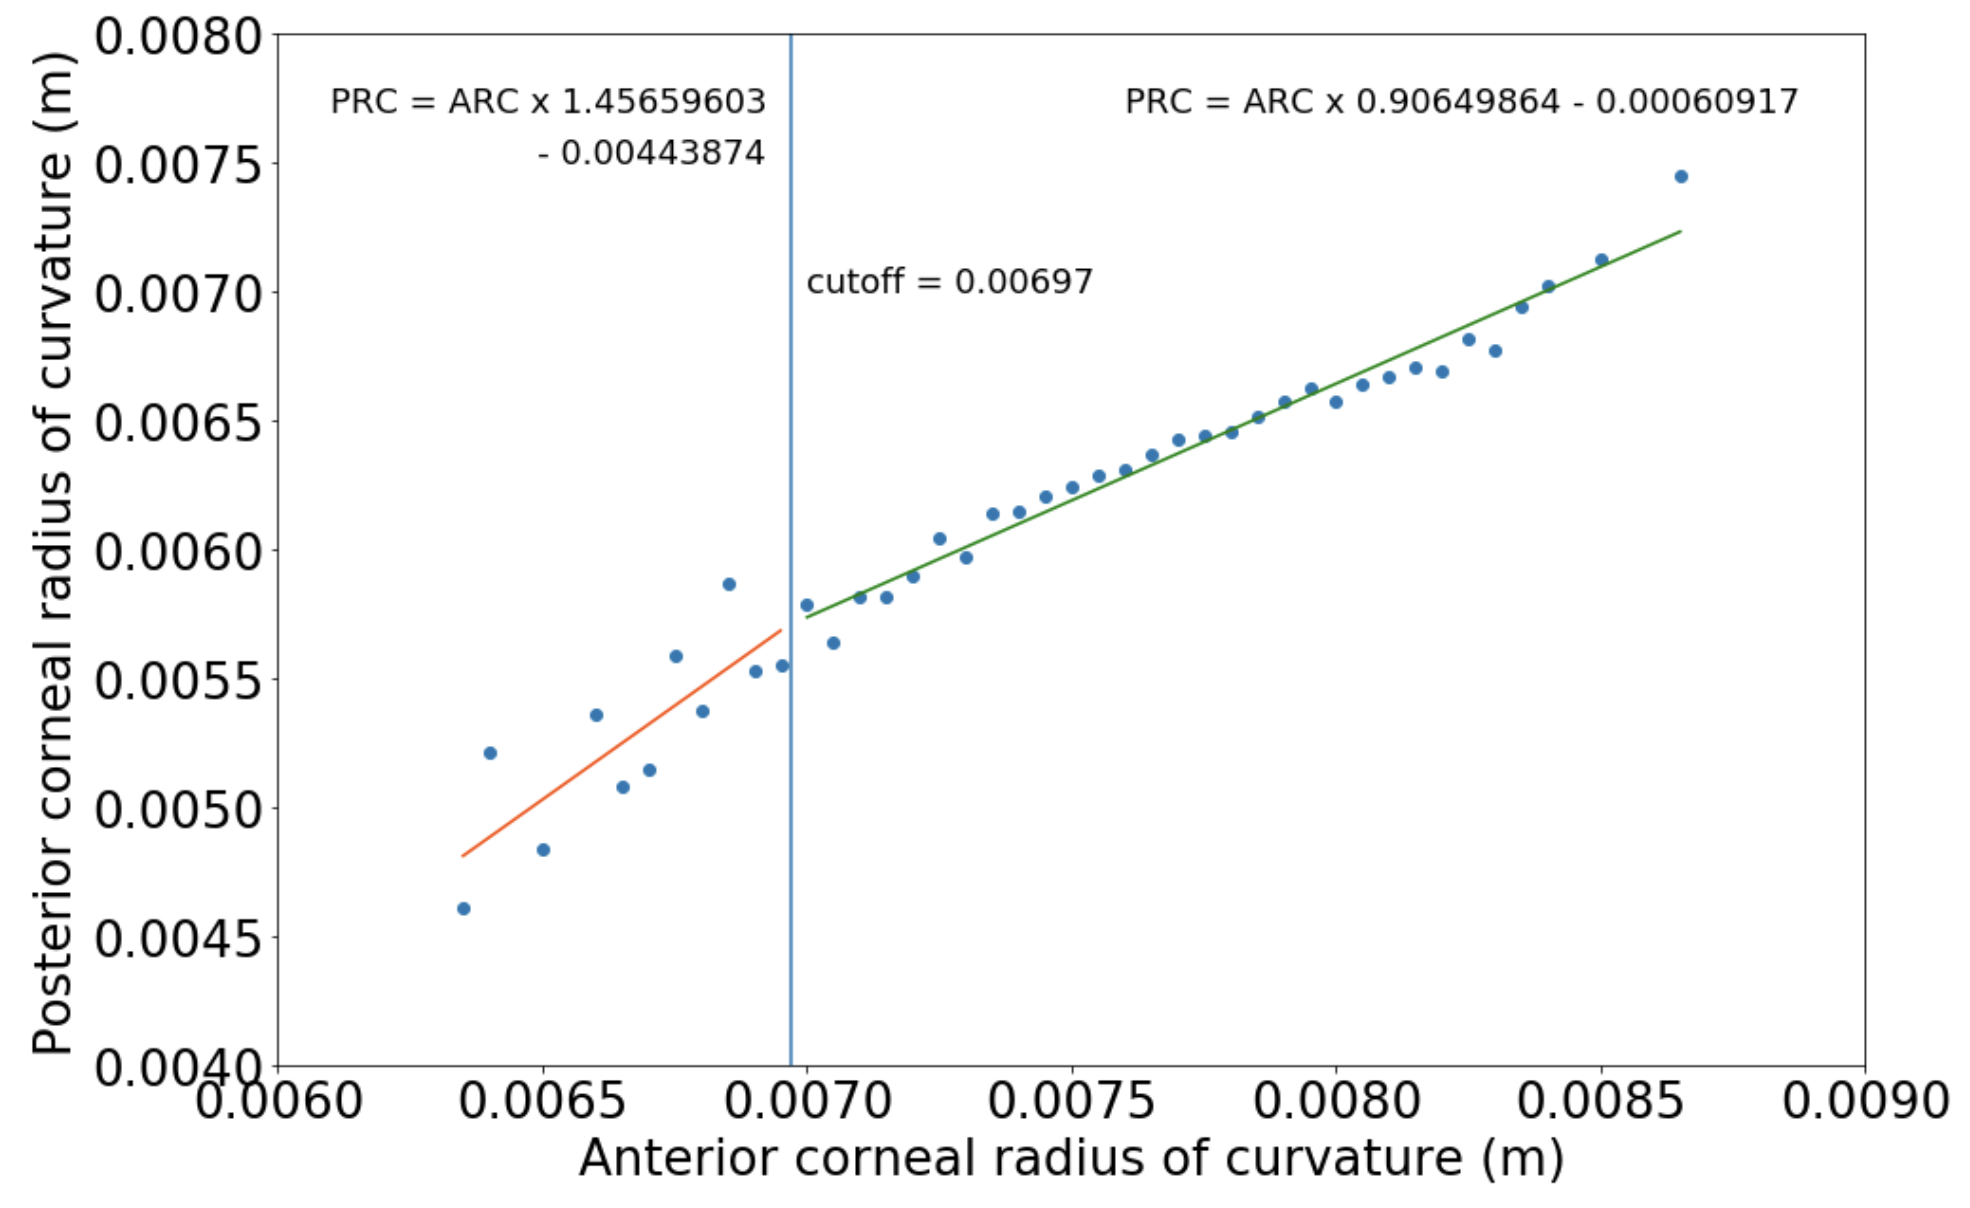

In [18]:
iol = pd.read_pickle( # path to the file containing IOL parameters )

In [19]:
# All IOL parameters in the dataframe must be in dioptres / meters.

In [20]:
# Example : 
iol[iol.Power == 21]

,Power,Riol1,Riol2,Thickness,niol
22,21.0,0.012071,-0.012184,0.000977,1.4619


In [21]:
df = pd.read_pickle( # path to the file containing the biometric data, IOL power data and postoperative SE )

In [23]:
# All biometric parameters must be in meters. Postop SE = dioptres.

In [24]:
# Example : 
df.iloc[0][['AL', 'R1', 'R2','ACD', 'LT', 'CCT',  'WTW', 'Power', 'SE_postop']]

AL           0.02486 
R1           0.00751 
R2           0.0073  
ACD          0.003499
LT           0.00431 
CCT          0.000559
WTW          0.01194 
Power        14      
SE_postop    0.125   
Name: 0, dtype: object

In [25]:
# Every sample in associated to the corresponding IOL parameters, depending on the IOL power that was
# chosen for the surgery
df = pd.merge(df, iol, on = 'Power', how = 'left')

In [26]:
###
#
# STEP 1 : INITIALIZATION AND DATA CLEANING
#
###

In [27]:
# Refractive indices of the Atchinson model eye
df['nco'] = 1.376
df['naq'] = 1.3374
df['nair'] = 1
df['nvit'] = 1.336
# Standard vertex distance (meters)
df['d'] = 0.012

In [28]:
# Mean ARC calculation
df['ARC'] = df[['R1', 'R2']].apply(lambda x : calcARC(*x), axis = 1)  

In [29]:
# Mean PRC prediction using the chosen rule (can be replaced with measured PRC if available)
df['PRC'] = df[['ARC']].apply(lambda x : predPRC(*x), axis = 1)  

In [30]:
# CMAL calculation (can be replaced with measured sum-of-segments AL if available)
df['CMAL'] = df[['AL', 'LT']].apply(lambda x : calculateSegmentedAL(*x), axis = 1)

In [31]:
# AQD = ACD - CCT
df['AQD'] = df['ACD'] - df['CCT']

In [32]:
# Reference TILP back-calculation
df['TILP'] = df[['nco', 'niol', 'nvit', 'nair', 'naq', 'ARC', 'PRC', 'CCT', 'Riol1', 'Riol2', 
                'Thickness', 'SE_postop', 'CMAL', 'd']].apply(lambda x : calcTILP(*x), axis = 1)

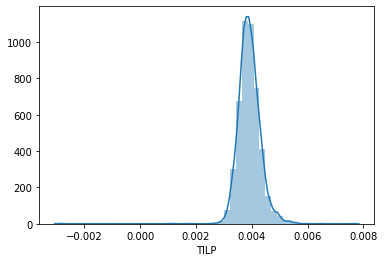

In [33]:
# Visualization of TILP distribution
sns.distplot(df.TILP)

In [34]:
# "Impossible" TILP values are discarded.
df = df[df.TILP < 0.007]
df = df[df.TILP > 0.0025]

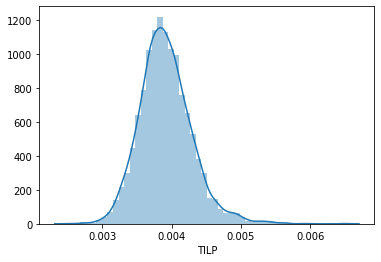

In [35]:
sns.distplot(df.TILP)

In [36]:
# "Impossible" AL, K, LT, ACD, CCT values must also be discarded. 
# This can be done using "common sense", and/or the same kind of distribution plot.

In [37]:
###
#
# STEP 2 : DETERMINATION OF THE OPTIMAL CORNEAL REFRACTIVE INDEX
#
# Summary : the process of reference TILP calculation - multiple regression fitting - TILP prediction - 
# predicted SE calculation - SD of prediction error calculation is done for a wide range of corneal
# refractive index values. The index yielding the lowest SD is chosen.
#
###

In [38]:
# name of the columns that will be used as features to predict the TILP
lsfeat = [ 'CMAL' , 'ARC' , 'AQD' ,'LT', 'CCT' , 'WTW']

# dictionnary initialisation
dic_sd = {}

In [39]:
# for each corneal index value between 1.3 and 1.4, by 0.001 steps :

for nco in np.arange(1.3, 1.4001, 0.001):
    
    # the evaluated corneal refractive index value is assigned to the dataset
    df.loc[:, 'nco'] = nco
    
    # the reference TILP is back-calculated using this value
    df['TILP'] = df[['nco', 'niol', 'nvit', 'nair', 'naq', 'ARC', 'PRC', 'CCT', 'Riol1', 'Riol2',
                    'Thickness', 'SE_postop', 'CMAL', 'd']].apply(lambda x : calcTILP(*x), axis = 1)
    
    # features dataframe :
    X =  df[lsfeat]
    # target column :
    y =  df['TILP']
    # model initialisation
    lin_model = LinearRegression()
    # model is fitted to the data
    lin_model.fit(X, y)
    # TILP is predicted
    df['TILP_pred'] = lin_model.predict(df[lsfeat])
    # Predicted SE is calculated
    df['SEpred'] = df[['nco', 'niol', 'nvit', 'nair', 'naq', 'ARC', 'PRC', 'CCT', 
                       'Riol1', 'Riol2', 'Thickness', 'TILP_pred', 'CMAL', 'd']].apply(lambda x : calcSE(*x), axis = 1)
    # Prediction error is calculated
    df['error'] = df['SE_postop'] - df['SEpred']
    # Standard deviation of prediction error is calculated
    std = df.error.std()
    # Each evaluated corneal refractive index is associated with its SD in a dict
    dic_sd[nco] = std

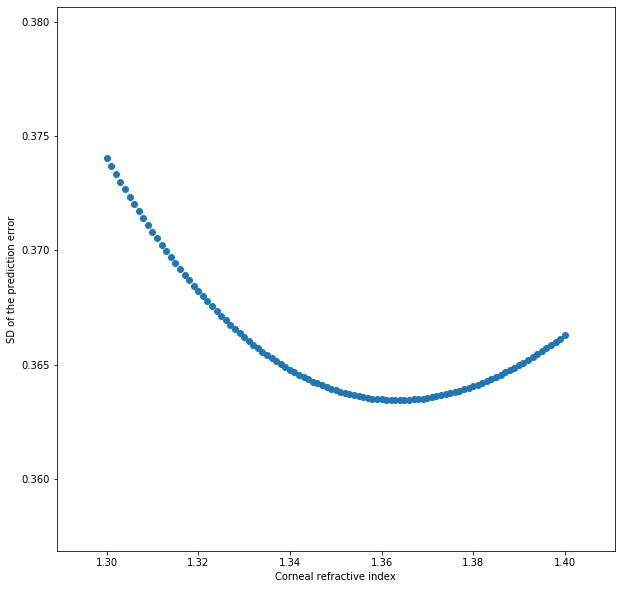

In [40]:
# Visualization of the SD of prediction error for each evaluated corneal refractive index value.
# The curve must be concave upward, else the upper or lower corneal refractive index limits must be adjusted

plt.figure(figsize = (10,10))
plt.scatter(dic_sd.keys(), dic_sd.values())
plt.xlabel('Corneal refractive index')
plt.ylabel('SD of the prediction error')
plt.show()

In [41]:
print('Best corneal refractive index : ' , round(min(dic_sd, key = dic_sd.get),3))
print('Best corresponding SD : ' , round(dic_sd[min(dic_sd, key = dic_sd.get)],3))

Best corneal refractive index :  1.363
Best corresponding SD :  0.363


In [42]:
# The best performing corneal refractive index is assigned to the dataset
df.loc[:, 'nco'] = round(min(dic_sd, key = dic_sd.get),3)

In [44]:
# The reference TILP is recalculated accordingly
df['TILP'] = df[['nco', 'niol', 'nvit', 'nair', 'naq', 'ARC', 'PRC', 'CCT', 'Riol1', 'Riol2', 
                'Thickness', 'SE_postop', 'CMAL', 'd']].apply(lambda x : calcTILP(*x), axis = 1)

In [45]:
# The model is retrained with the new reference TILP value
lin_model = LinearRegression()
lsfeat = [ 'CMAL' , 'ARC' , 'AQD' ,'LT', 'CCT','WTW' ]
X =  df[lsfeat]
y =  df['TILP']
lin_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
# The predicted TILP is calculated
df['TILP_pred'] = lin_model.predict(X)

In [48]:
###
#
# STEP 3 : SHORT AND LONG EYES TILP PREDICTION CORRECTION 
#
# Summary : the mean TILP prediction error is visualized for each 0.25mm AL step. 
# This prediction error exists for short and long eyes after a certain limit, proportionnally to 
# to the distance to this limit. 
# It is corrected by modifying the AL value that is used as an input in the algorithm.
#
###

In [49]:
# ORIGINAL OUTPUT : 

# A column containing original AL values (not CMAL) rounded to the nearest 0.25mm is created.

def nearest00025(x):
    return round(x / 0.00025) * 0.00025

df['ALr'] =  df[['AL']].apply(lambda x : nearest00025(*x), axis = 1)

In [50]:
# Mean back-calculated TILP values are calculated for each AL step.
# The same is done for predicted TILP values (using non-modified CMAL as a predictor).
x = 'ALr'
y1 = 'TILP'
y2 = 'TILP_pred'
ref_TILP_serie = df.groupby(x)[y1].mean()
pred_TILP_serie = df.groupby(x)[y2].mean()

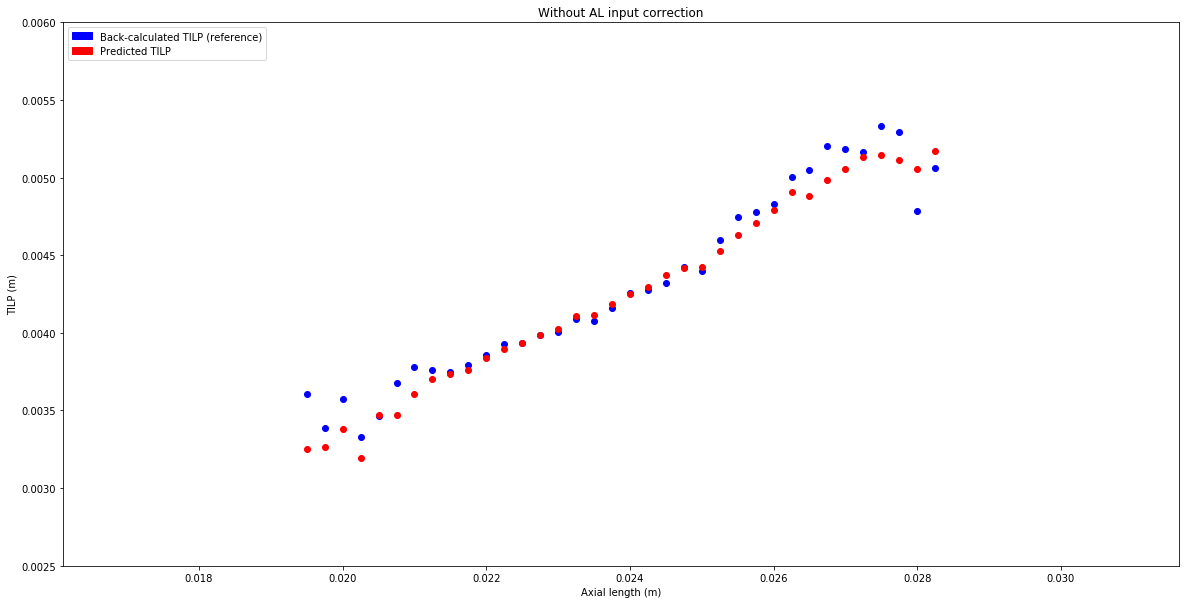

In [51]:
# Those values are represented on a scatter plot.
# This is the "basic state" of the TILP prediction algorithm

plt.figure(figsize = (20,10))
plt.scatter(ref_TILP_serie.index, ref_TILP_serie.values, c = 'b')
plt.scatter(pred_TILP_serie.index, pred_TILP_serie.values, c = 'r')

plt.ylim(0.0025,0.006)

plt.xlabel('Axial length (m)')
plt.ylabel('TILP (m)')
plt.title('Without AL input correction')
box1 = mpatches.Patch(color = 'b', label = 'Back-calculated TILP (reference)')
box2 = mpatches.Patch(color = 'r', label = 'Predicted TILP')
plt.legend(handles = [box1, box2], loc = 'upper left')
plt.show()

In [52]:
# The graph above shows that our multiple regression underestimates TILP values for very short and 
# very long eyes.
# --> Limits are set visually at 21.5 and 25mm.

lower_lim = 0.0215
upper_lim = 0.025

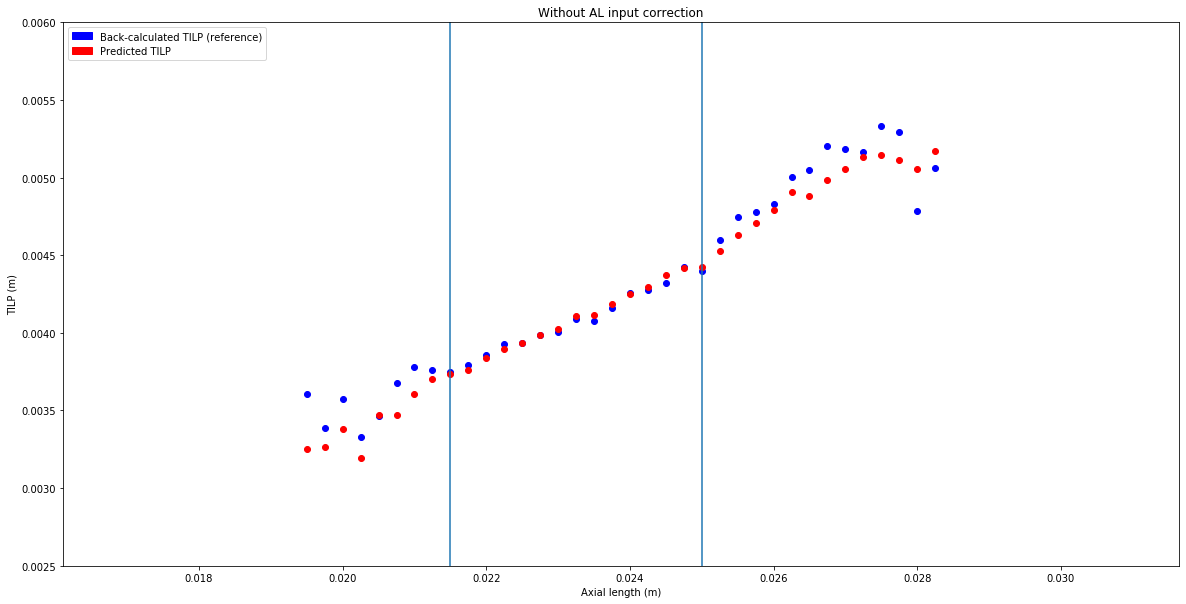

In [53]:
# Same scatter plot with limits plotted


plt.figure(figsize = (20,10))
plt.scatter(ref_TILP_serie.index, ref_TILP_serie.values, c = 'b')
plt.scatter(pred_TILP_serie.index, pred_TILP_serie.values, c = 'r')

plt.axvline(lower_lim)
plt.axvline(upper_lim)

plt.ylim(0.0025,0.006)

plt.xlabel('Axial length (m)')
plt.ylabel('TILP (m)')
plt.title('Without AL input correction')
box1 = mpatches.Patch(color = 'b', label = 'Back-calculated TILP (reference)')
box2 = mpatches.Patch(color = 'r', label = 'Predicted TILP')
plt.legend(handles = [box1, box2], loc = 'upper left')
plt.show()

In [54]:
# The AL correction consists in modifying the CMAL value used as an input in the prediction algorithm, 
# by adding a correction factor to i. This correction factor is proportional to the delta between the 
# AL of the eye and the chosen upper/lower AL limit. 

# NB : The original CMAL is always used for optical calculations, whatever the AL.

# If an eye is shorter than 21.5mm, the shorter it is, the greater the correction factor applied.
# The same reasoning is used for eyes longer than 25mm.

# The correction factor is defined by the product of the absolute value of the difference between the AL and 
# and the upper/lower limit by a coefficient (correction factor = |real AL - AL limit| * coef).

# There is one coefficient value for short eyes, and one for long eyes. They must now be determined.

# The coefficient is determined using a loop where different coefficient values are tested, 
# the coefficient-modified predicted TILP being calculated for each coefficient.
# The coefficient leading to the lowest residual TILP prediction error is kept.

In [55]:
# All those coefficients, ranging from -2 to 2 are going to be tested
coef_range = np.arange(-2, 2.1,0.1)
print([round(x,1) for x in coef_range])

[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


In [56]:
# Coefficient determination for short eyes :
# Every coefficient value is tested in a loop

# dictionnary initialisation
dic_delta_slope_short = {}
# The best coefficient is determined by trying to minimize the difference between the mean reference TILP value 
# and the mean predicted TILP value for each AL step.

# Table containing the mean reference TILP for eyes shorter or equal to 21.5mm (reference table):
ref_TILP_serie_short = ref_TILP_serie[ref_TILP_serie.index <= lower_lim]
# Dataset containing all the eyes that are shorter than or equal to 21.5mm :
df_short = df[df.AL <= lower_lim]
# The column 'short_limit' is set to the lower AL limit previously chosen
df_short.loc[:, 'short_limit'] = lower_lim

# For every coefficient tested :
for coef in coef_range:
    
    # A column containing the evaluated coefficient is added to the dataset
    df_short.loc[:, 'correction_coef'] = coef
    
    # A column containing the difference between the lower limit and the AL of the evaluated eye is created
    # ("short limit" is always greater or equal to AL, by definition)
    df_short['delta_AL'] = df_short['short_limit'] - df_short['AL']
    
    # The correction factor is equal to delta_AL multiplicated by the evaluated coefficient
    df_short['correction_factor'] = df_short['delta_AL'] * df_short['correction_coef']
    
    # The corrected CMAL is equal to CMAL + the correction factor
    df_short['corrected_CMAL'] = df_short['CMAL'] + df_short['correction_factor']
    
    # The new predicted TILP values are calculated using the corrected CMAL instead of the original CMAL
    df_short['TILP_pred'] = lin_model.predict(df_short[[ 'corrected_CMAL' , 'ARC' , 'AQD' ,'LT', 'CCT','WTW' ]])
    
    # The table containing the new mean predicted TILP for each AL step is created
    short_serie_pred = df_short.groupby('ALr')['TILP_pred'].mean()
    
    # The table containing the delta between mean predicted and mean reference TILP, for each AL step, 
    # is calculated
    delta_series_short = short_serie_pred - ref_TILP_serie_short
    
    # The mean global error value ( = mean error for all AL steps together) is calculated
    residual_error_short = delta_series_short.mean()
    
    # Each coefficient is associated with the absolute value of the mean global error in a dict 
    dic_delta_slope_short[coef] = abs(residual_error_short)

In [57]:
# resulting dictionnary : each coefficient is associated to its corresponding absolute mean global error
dic_delta_slope_short

{-2.0: 0.0006591311951166753,
 -1.9: 0.0006339216187867419,
 -1.7999999999999998: 0.0006087120424568082,
 -1.6999999999999997: 0.0005835024661268748,
 -1.5999999999999996: 0.0005582928897969415,
 -1.4999999999999996: 0.0005330833134670079,
 -1.3999999999999995: 0.0005078737371370747,
 -1.2999999999999994: 0.0004826641608071412,
 -1.1999999999999993: 0.0004574545844772077,
 -1.0999999999999992: 0.00043224500814727446,
 -0.9999999999999991: 0.0004070354318173412,
 -0.899999999999999: 0.0003818258554874076,
 -0.7999999999999989: 0.0003566162791574742,
 -0.6999999999999988: 0.0003314067028275409,
 -0.5999999999999988: 0.0003061971264976076,
 -0.49999999999999867: 0.00028098755016767423,
 -0.3999999999999986: 0.00025577797383774054,
 -0.2999999999999985: 0.0002305683975078076,
 -0.1999999999999984: 0.000205358821177874,
 -0.09999999999999831: 0.00018014924484794037,
 1.7763568394002505e-15: 0.00015493966851800705,
 0.10000000000000187: 0.00012973009218807363,
 0.20000000000000195: 0.0001045

In [58]:
# Coefficient associated with the lowest mean global error value :
best_coef_short = min(dic_delta_slope_short, key = dic_delta_slope_short.get)
print(best_coef_short)

0.6000000000000023


In [59]:
# Same procedure for long eyes :
# Every coefficient value is tested in a loop

# dictionnary initialisation
dic_delta_slope_long = {}
# The coefficient is determined by studying the difference between the mean reference TILP value 
# and the mean predicted TILP value for each AL step.
# Table containing the mean reference TILP for eyes longuer or equal to 25mm (reference table):
ref_TILP_serie_long = ref_TILP_serie[ref_TILP_serie.index >= upper_lim]
# Dataset containing all the eyes that are shorter than or equal to 25mm
df_long = df[df.AL >= upper_lim]
# The column 'short_limit' is set to the upper AL limit previously chosen
df_long.loc[:, 'long_limit'] = upper_lim

for coef in coef_range:
    # A column containing the evaluated coefficient is added to the dataset
    df_long.loc[:, 'correction_coef'] = coef
    
    # A column containing the difference between the lower limit and the AL of the evaluated eye is created
    # ("short limit" is always greater or equal to AL)
    df_long['delta_AL'] = df_long['AL'] - df_long['long_limit']
    
    # The correction factor is equal to delta_AL multiplicated by the evaluated coefficient
    df_long['correction_factor'] = df_long['delta_AL'] * df_long['correction_coef']
    
    # The corrected CMAL is equal to CMAL + the correction factor
    df_long['corrected_CMAL'] = df_long['CMAL'] + df_long['correction_factor']
    
    # The new predicted TILP values are calculated using the corrected CMAL instead of the original CMAL
    df_long['TILP_pred'] = lin_model.predict(df_long[[ 'corrected_CMAL' , 'ARC' , 'AQD' ,'LT', 'CCT','WTW' ]])
    
    # The table containing the new mean predicted TILP for each AL step is created
    long_serie_pred = df_long.groupby('ALr')['TILP_pred'].mean()
    
    # The table containing the delta between mean predicted and mean reference TILP, for each AL step, 
    # is calculated
    delta_series_long = long_serie_pred - ref_TILP_serie_long
    
    # The mean global error value ( = mean error for all AL steps together) is calculated
    residual_error_long = delta_series_long.mean()
    
    # Each coefficient is associated with the absolute value of the mean global error in a dict
    dic_delta_slope_long[coef] = abs(residual_error_long)

In [60]:
best_coef_long = min(dic_delta_slope_long, key = dic_delta_slope_long.get)
print(best_coef_long)

0.20000000000000195


In [62]:
def correctCMAL(AL, CMAL):    
    '''
    This function allows to correct the CMAL values that are used as inputs in the TILP prediction
    algorithm, according to the coefficients and limits that were determined above.  
    '''
    if AL <= lower_lim:
        weight = lower_lim - AL
        delta = weight * best_coef_short
        ALcorr = CMAL + delta
    elif AL >= upper_lim:
        weight = AL - upper_lim
        delta = weight * best_coef_long
        ALcorr = CMAL + delta
    else:
        delta = 0
        ALcorr = CMAL + delta
    return ALcorr

In [63]:
# CMAL_corr is calculated using the previous function. NB : The function return the CMAL value without 
# modification if AL is greater than 21.5mm and lower than 25mm

df['CMAL_corr'] = df[['AL', 'CMAL']].apply(lambda x : correctCMAL(*x), axis = 1)

In [64]:
# The predicted TILP is recalculated using CMAL_corr
lsfeat = [ 'CMAL_corr' , 'ARC' , 'AQD' ,'LT', 'CCT','WTW' ]
X = df[lsfeat]
df['TILP_pred_corr'] = lin_model.predict(X)

In [65]:
# Mean back-calculated TILP values are calculated for each AL category.
# The same is done for predicted TILP values.
x = 'ALr'
y1 = 'TILP'
y2 = 'TILP_pred_corr'
ref_TILP_corr_serie = df.groupby(x)[y1].mean()
pred_TILP_corr_serie = df.groupby(x)[y2].mean()

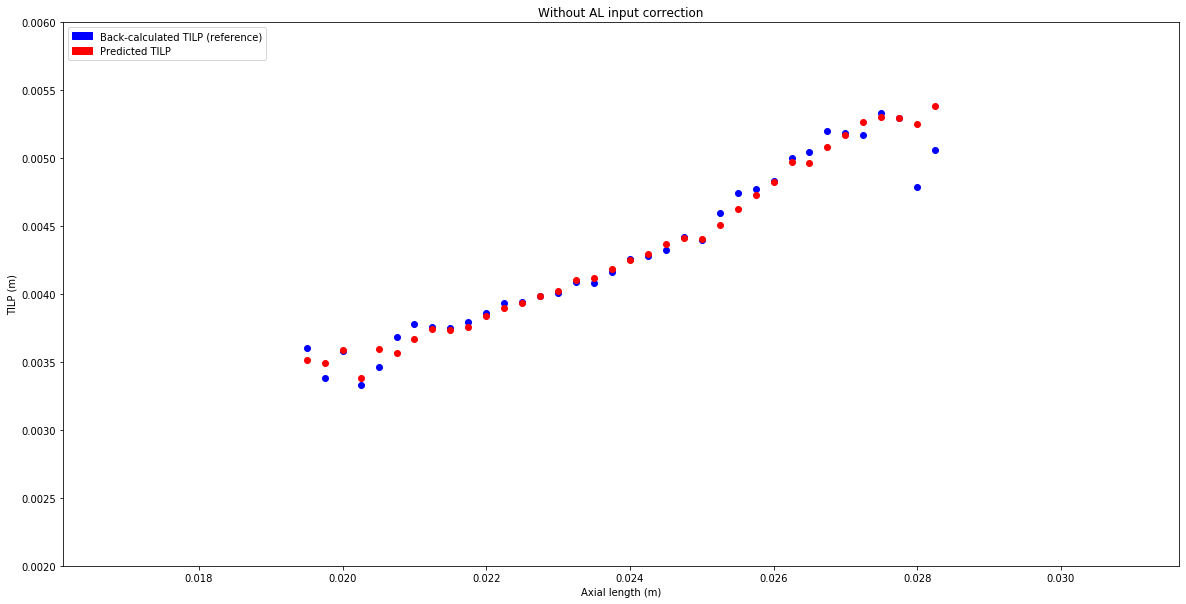

In [66]:
# The new values are represented on a scatter plot.
# The TILP prediction for short and long eyes is now corrected

plt.figure(figsize = (20,10))
plt.scatter(ref_TILP_corr_serie.index, ref_TILP_corr_serie.values, c = 'b')
plt.scatter(pred_TILP_corr_serie.index, pred_TILP_corr_serie.values, c = 'r')

plt.ylim(0.002,0.006)

plt.xlabel('Axial length (m)')
plt.ylabel('TILP (m)')
plt.title('Without AL input correction')
box1 = mpatches.Patch(color = 'b', label = 'Back-calculated TILP (reference)')
box2 = mpatches.Patch(color = 'r', label = 'Predicted TILP')
plt.legend(handles = [box1, box2], loc = 'upper left')
plt.show()

In [67]:
# The TILPshift column is used to adjust the formula, when predictions for other FineVision dataset
# must be evaluated.
# Here it is set to zero
df.loc[:, 'TILPshift'] = 0

In [68]:
# Once the best corneal refractive index is determined, the final TILP prediction algorithm is trained,
# and the TILP correcting function is created (all this work must be done only once...), the formula is ready.
# The prediction is straighforward.
# All the steps are summarized here : 


def predPearl(nco, niol, nvit, nair, naq, AL, R1, R2, ACD, LT, CCT, WTW, Riol1, Riol2, IOLt, d, TILPshift):
    
    # AQD is calculated
    AQD = ACD - CCT
    # ARC is calculated
    ARC = calcARC(R1, R2)
    # PRC is predicted
    PRC = predPRC(ARC)
    # CMAL is calculated
    CMAL = calculateSegmentedAL(AL, LT)
    # CMAL_corr is calculated
    CMAL_corr = correctCMAL(AL, CMAL)
    # TILP is predicted
    TILP_corr = lin_model.predict(np.array([CMAL_corr, ARC, AQD, LT, CCT, WTW]).reshape(1, -1))
    # Shift is added if necessary
    TILP_corr += TILPshift
    # Predicted SE is calculated
    SEpred = calcSE(nco, niol, nvit, nair, naq, ARC, PRC, CCT, Riol1, Riol2, IOLt, TILP_corr, CMAL, d)
    
    return SEpred[0]

In [69]:
# SE Calculation : 
df['SEpred'] = df[['nco', 'niol', 'nvit', 'nair', 'naq', 'AL', 'R1', 'R2', 'ACD', 'LT', 'CCT', 'WTW', 
                   'Riol1', 'Riol2', 'Thickness', 'd', 'TILPshift']].apply(lambda x : predPearl(*x), axis = 1)

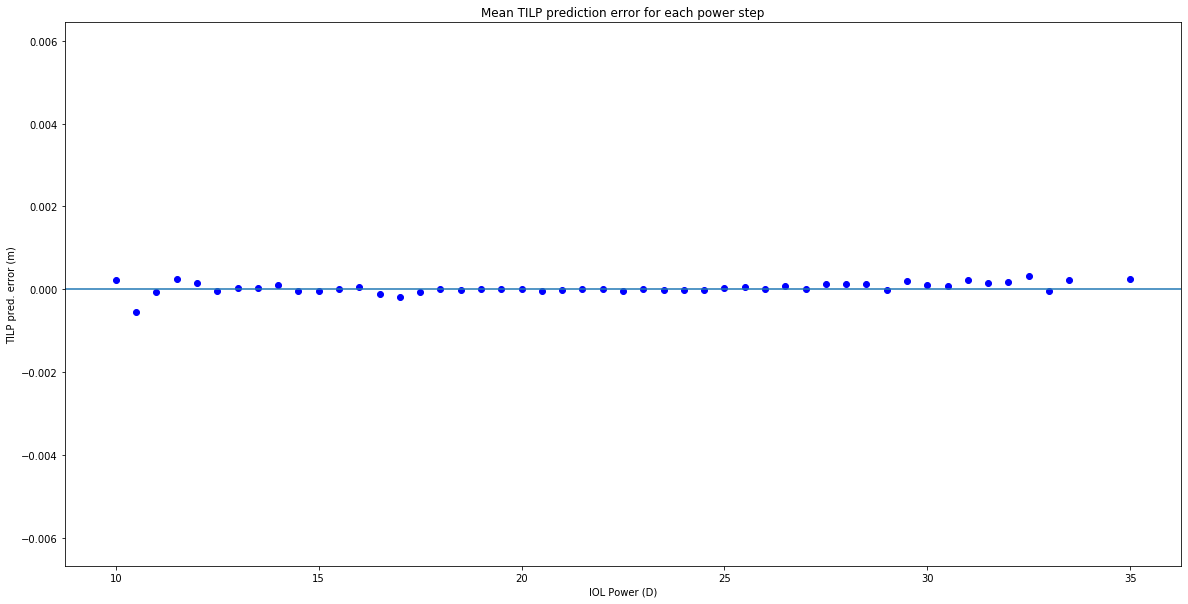

In [70]:
# If the precise IOL geometry is unknown, it is also possible to develop a formula with theoretical 
# IOL parameters. It is possible, for example, to use the real refractive index of the IOL 
# (which is usually public), plausible thickness for each power step, and curvature radii yielding the 
# expected power.
# In a situation where the IOL geometry used in the formula is theoretical, we advise to study the mean TILP
# prediction error for each IOL power step. This can give hints about IOL geometry variations of a specific
# lens along its power range and allow the formula inventor to apply the appropriate correction.
# In our case, the IOL geometry is known, no IOL power related error is expected.

df['TILP_pred_error'] = df['TILP'] - df['TILP_pred']

x = 'Power'
y = 'TILP_pred_error'
ref_TILP_serie = df.groupby(x)[y].mean()
plt.figure(figsize = (20,10))

plt.xlabel('IOL Power (D)')
plt.ylabel('TILP pred. error (m)')
plt.title('Mean TILP prediction error for each power step')

plt.scatter(ref_TILP_serie.index, ref_TILP_serie.values, c = 'b')
plt.axhline(0)
plt.show()

In [71]:
# In this Notebook, a basic multiple regression was used to better visualize the threshold effects of the 
# AL on the TILP value. However, once the TILP value is back-calculated, it is straightforward to use 
# more complex algorithms to predict this value.
# Examples are provided below (hyperparameters tuning steps are mandatory but 
# go beyond the scope of this paper)

In [73]:
# example with a multilayer perceptron regressor algorithm :

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
lsfeat = [ 'CMAL' , 'ARC' , 'AQD' ,'LT', 'CCT','WTW' ]
mlp.fit(df[lsfeat], df['TILP'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [74]:
# example with an XGBoost algorithm :

import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
lspredictors = ['CMAL', 'R1', 'R2', 'AQD', 'LT', 'CCT', 'WTW']
xgb_model.fit(df[lspredictors], df['TILP'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [75]:
# example with two SVR algorithms (linear kernel and rbf kernel) :

from sklearn.svm import SVR
svr_model_rbf = SVR(kernel ='rbf', gamma = 'scale' )
svr_model_lin = SVR(kernel ='linear', gamma = 'scale')
lspredictors = ['CMAL', 'R1', 'R2', 'AQD', 'LT', 'CCT', 'WTW']
svr_model_rbf.fit(df[lspredictors], df['TILP'])
svr_model_lin.fit(df[lspredictors], df['TILP'])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)